# Computational Project I:
# Association Rules and Prediction Rules for Financial Data Miningc

## Import packages

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
from functools import partial
from itertools import product
from IPython.display import display,Markdown

## Download data

Download the time series of `MSFT` and `GOOGL`’s daily closing price started from `2005-01-01` to now from Yahoo Finance with `yfinance` package.

In [2]:
msft = yf.download("MSFT",start="2005-01-01",threads=False)
google = yf.download("GOOGL",start="2005-01-01",threads=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
S = pd.DataFrame(index = msft.index)
S["MSFT"] = msft['Adj Close'] 
S["GOOGL"] = google['Adj Close'] 
S

,MSFT,GOOGL
Date,,
2005-01-03,18.813696,5.072823
2005-01-04,18.884056,4.867367
2005-01-05,18.841835,4.842593
2005-01-06,18.820732,4.718468
2005-01-07,18.764444,4.851101
...,...,...
2023-03-16,276.200012,100.320000
2023-03-17,279.429993,101.620003
2023-03-20,272.230011,101.220001


## Data Preprocessing

Let time start at $t=0$. Denote the stock’s time series by 𝑆(𝑡), then compute its daily return rate 𝑋(𝑡) with

$$
X(t) = ln [\frac{S(t)}{S(t-1)}]
$$

and denote the length of 𝑋(𝑡) by 𝑁 .

In [4]:
X = np.log(S).diff()
X

,MSFT,GOOGL
Date,,
2005-01-03,NaN,NaN
2005-01-04,0.003733,-0.041344
2005-01-05,-0.002238,-0.005103
2005-01-06,-0.001121,-0.025966
2005-01-07,-0.002995,0.027721
...,...,...
2023-03-16,0.039736,0.042872
2023-03-17,0.011627,0.012875
2023-03-20,-0.026104,-0.003944


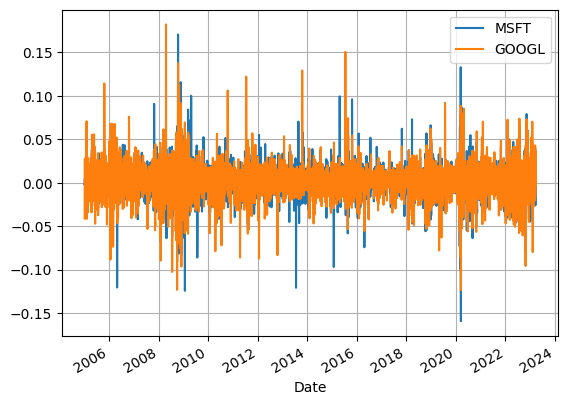

In [5]:
X.plot()
plt.grid(True)
plt.show()

## 2 Exponential moving average
Define the stock’s 𝑤-day exponential moving average (EMA) at time 𝑡 as
$$
𝑀 (𝑡, 𝑤) = 𝑎𝑆(𝑡) + (1 − 𝑎)𝑀 (𝑡 − 1, 𝑤)
$$
for some smoothing constant 𝑎. The base case is $𝑀 (0, 𝑤) ≡ 𝑆(0)$.

- Consider 𝑎 = 1/𝑤. Plot 𝑀 (𝑡, 𝑤) for 𝑤 = 30, 100, and 300. The three win-
dows roughly correspond to one month, one season, and one year.

In [6]:
def EMA(S:pd.DataFrame,omega=30,afn=lambda w:1/w):
    a = afn(omega)
    M = S.copy()
    M.iloc[0] = S.iloc[0]
    for t in range(1,len(S)):
        M.iloc[t] = a*S.iloc[t] + (1-a)*M.iloc[t-1]
    return M

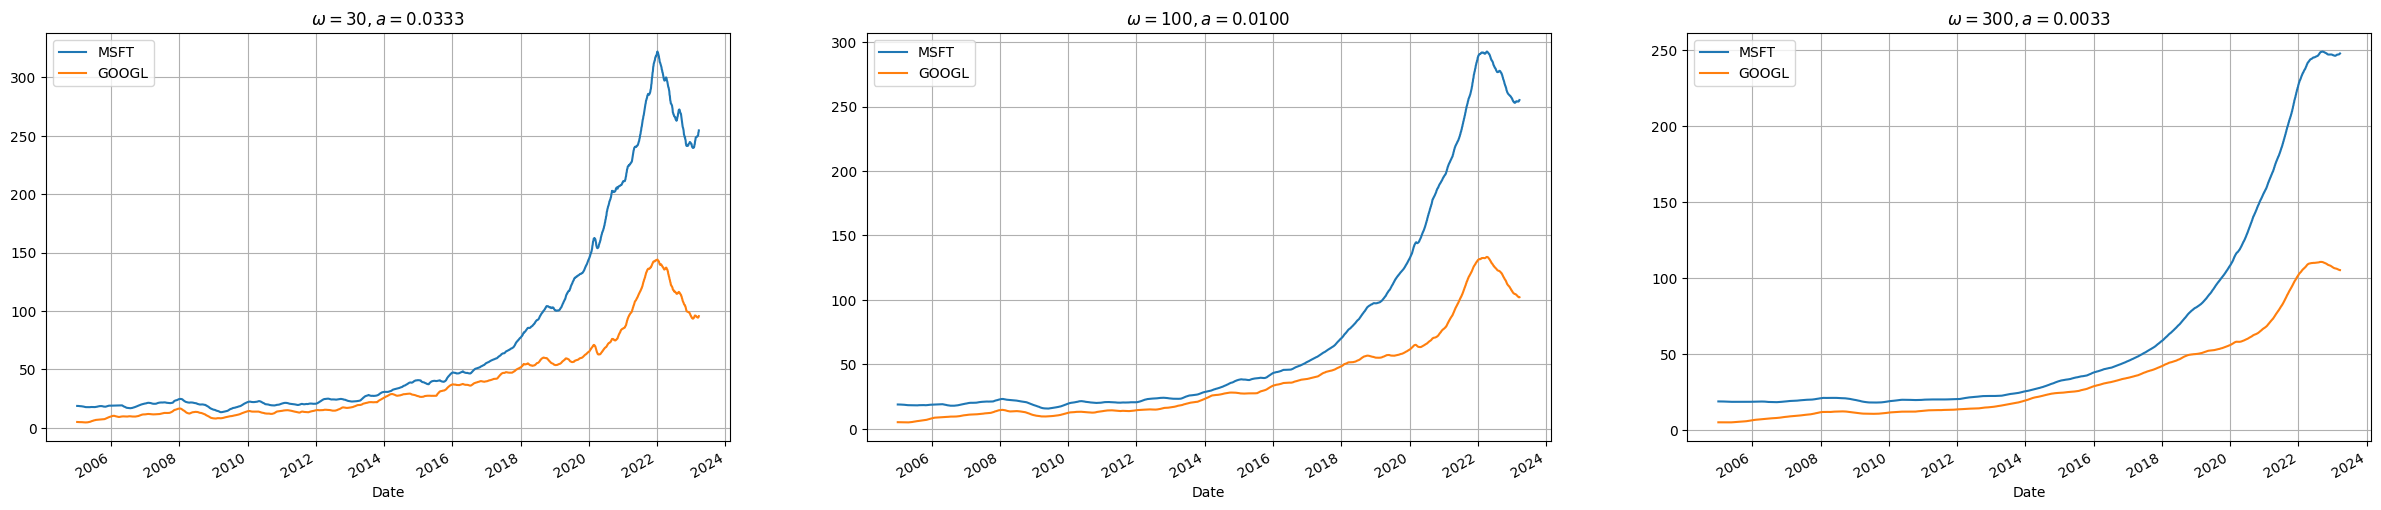

In [7]:
afn = lambda w:1/w
Ms = {w:EMA(S,w,afn=afn) for w in (30,100,300)}
num = len(Ms)
fig, axes = plt.subplots(1,3,figsize=(30,6))
for ax,(w,M) in zip(axes,Ms.items()):
    M.plot(ax=ax)
    ax.set_title(rf"$\omega={w},a={afn(w):.4f}$")
    ax.grid(True)
plt.show()

- Repeat last step using 𝑎 = 2/(𝑤 + 1), which is the prevalent definition in
finance

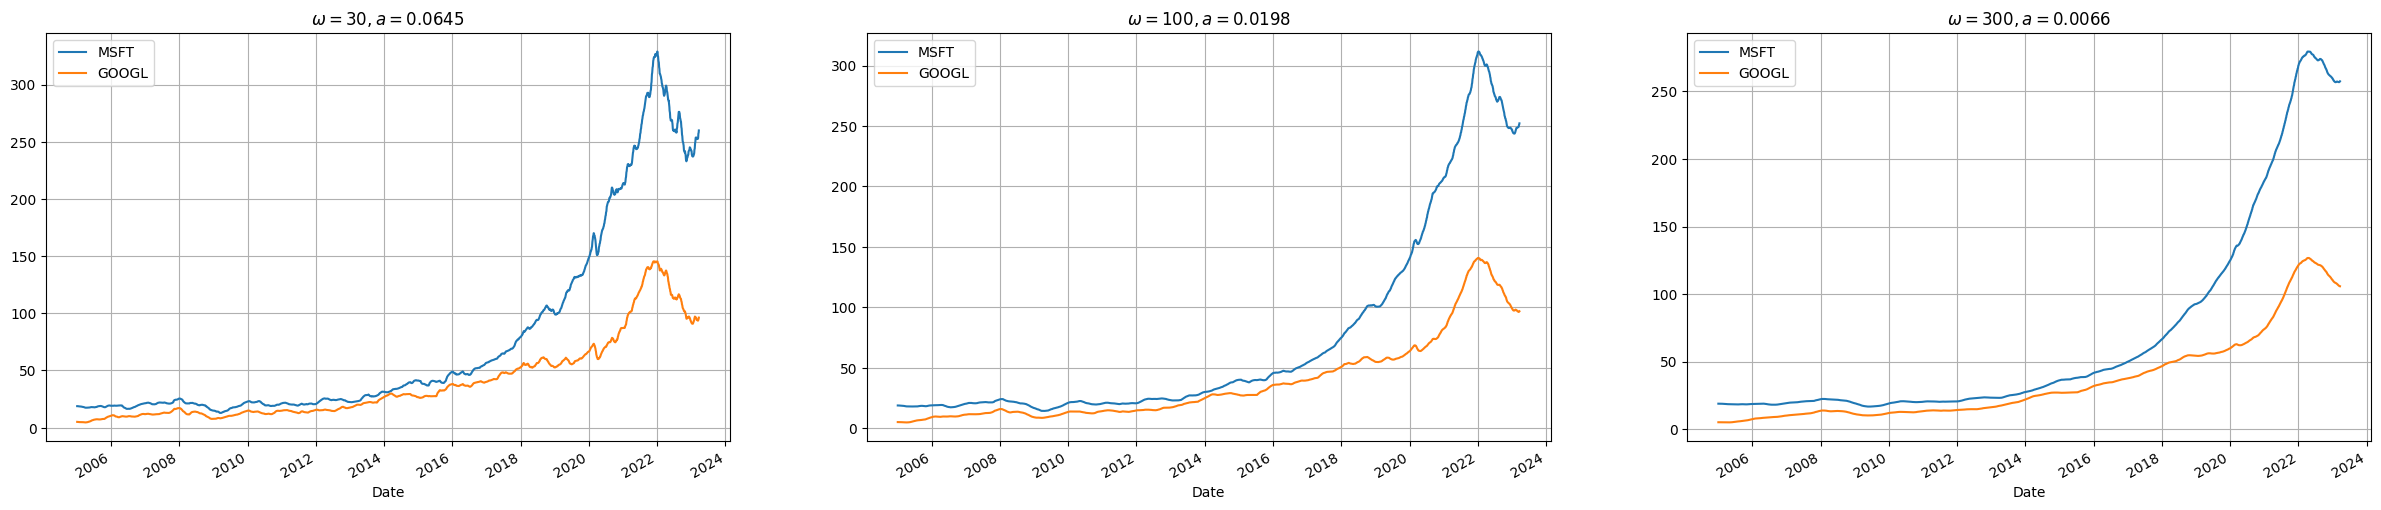

In [8]:
afn = lambda w:2/(w+1)
Ms = {w:EMA(S,w,afn=afn) for w in (30,100,300)}
num = len(Ms)
fig, axes = plt.subplots(1,3,figsize=(30,6))
for ax,(w,M) in zip(axes,Ms.items()):
    M.plot(ax=ax)
    ax.set_title(rf"$\omega={w},a={afn(w):.4f}$")
    ax.grid(True)
plt.show()

# 3 Cumulative Distribution Function
Let us regard the values of 𝑋(𝑡) as realizations of a random variable 𝑋.
Plot its CDF $F_X (x)$.

In [9]:
def ecdf(Xs:pd.Series,x):
    return (Xs <= x).mean()

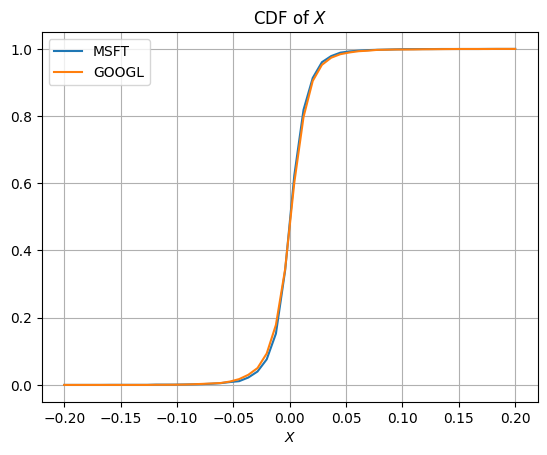

In [10]:
x_range = np.linspace(-0.2,0.2,50)
for stock in X.columns:
    ecdfval = list(map(partial(ecdf,X[stock]),x_range))
    plt.plot(x_range,ecdfval,label=stock)
plt.title("CDF of $X$")
plt.xlabel("$X$")
plt.legend()
plt.grid(True)
plt.show()

### 3.1 Logistic Function
We may fit $F_X (x)$ with a logistic function
$$
L(x) = \frac1{1 + \exp[−b(x-x^*)]} .
$$ 
In physics, this is also called a Fermi-Dirac distribution.
- What is $L(x^*)$ and hence your empirical $x^*$?
    $$
    L(x^*) = \frac12 .
    $$

    Thus, $x^*=L^{-1}(\frac12)=F_X^{-1}(\frac12)=quantile(X,\frac12)$.
- What is $L^{'}(x^*)$ and hence your empirical $b$?.
    $$
    L^{'}(x) = \frac{b\exp[−b(x-x^*)]}{(1+\exp[−b(x-x^*)])^2} .
    $$
    $$
    L^{'}(x^*) = \frac{b}{4} .
    $$

    Thus, $b=4L^{'}(x^*)=4F_X^{'}(x^*)\approx 4\frac{F_X(x^*+\delta x)-F_X(x^*-\delta x)}{2\delta x}$.

- Plot your empirical $L(x)$ atop $F_X(x)$.

In [11]:
def logistic(x,x_star=0,b=1):
    return 1/(1+np.exp(-b*(x-x_star)))

def logistic_derivate(x,x_star=0,b=1):
    e = np.exp(-b*(x-x_star))
    return b*e/(1+e)**2

def logistic_fit(Xs:pd.Series,dx=0.01):
    x_star = Xs.quantile(1/2)
    FX_u = ecdf(Xs,x_star+dx)
    FX_d = ecdf(Xs,x_star-dx)
    b = (FX_u-FX_d)*2/dx
    return x_star,b

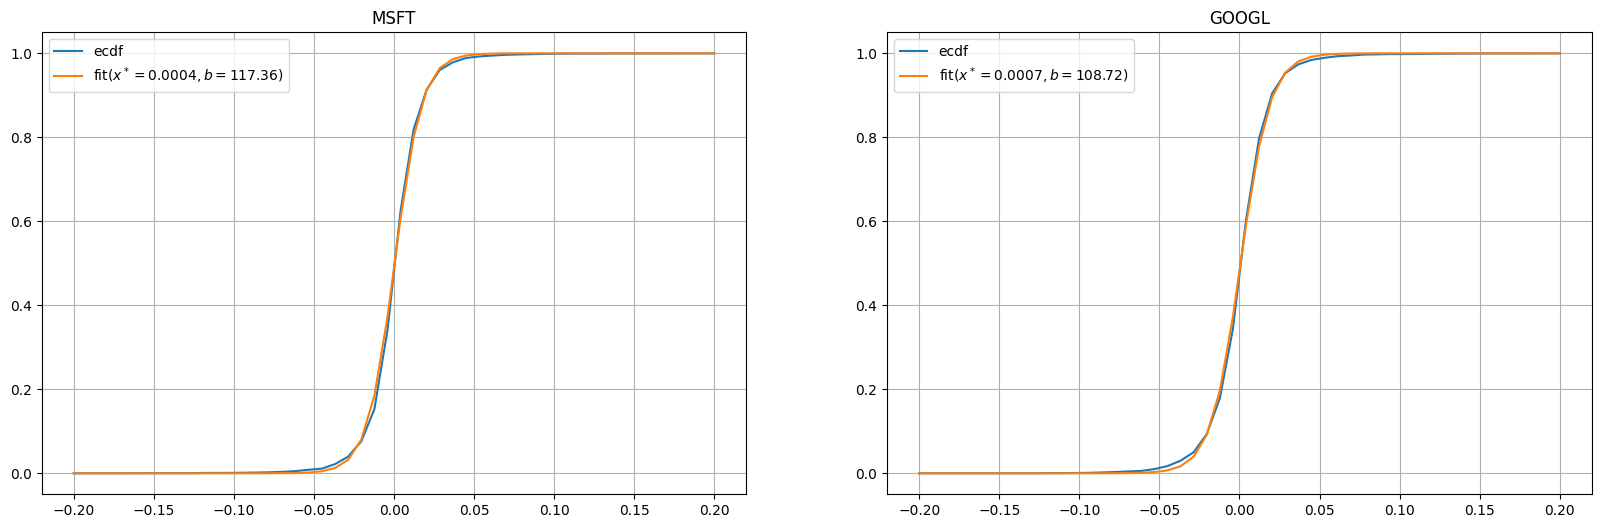

In [12]:
x_range = np.linspace(-0.2,0.2,50)
m = len(X.columns)
fig, axes = plt.subplots(1,2,figsize=(20,6))
for stock,ax in zip(X.columns,axes):
    ax.set_title(f"{stock}")
    ecdfval = list(map(partial(ecdf,X[stock]),x_range))
    ax.plot(x_range,ecdfval,label="ecdf")
    x_star,b = logistic_fit(X[stock],dx=0.01)
    fitval = logistic(x_range,x_star=x_star,b=b)
    ax.plot(x_range,fitval,label=rf"fit($x^*={x_star:.4f},b={b:.2f}$)")
    ax.legend()
    ax.grid(True)
plt.show()

### 3.2 Kolmogorov-Smirnov Test
We can test if our fitting is good with the Kolmogorov-Smirnov test. Our null
hypothesis is that $L(x)$ fits $F_X (x)$ well. Define $D = \max_x֓|F_X(𝑥) - L(𝑥)|$. 
If $\sqrt{N} D > \eta_{\alpha}$ , we reject the null hypothesis at a significance level $\alpha$. The
threshold $\eta_{\alpha}$ solves
$$
\frac{\sqrt{2\eta_{\alpha}}}{\eta_{\alpha}}\sum_{k=1}^{\infty}\exp\left[-\frac{(2k-1)^2\pi^2}{8\eta_{\alpha}^2}\right]=1-\alpha
$$
- Does the test reject the null hypothesis at 𝛼 = 0.05? At this significance
level, the null hypothesis is wrongly rejected once every 20 times.

In [13]:
from scipy.special import kolmogi

def ks_test(FX:np.ndarray,L:np.ndarray,alpha=0.05):
    N = len(FX)
    D = (FX-L).max()
    eta = kolmogi(1-alpha)
    stats = N**.5*D
    result = stats > eta
    return result,stats,eta

In [14]:
x_range = np.linspace(-0.2,0.2,50)
alpha = 0.05
for stock in X.columns:
    FX = list(map(partial(ecdf,X[stock]),x_range))
    x_star,b = logistic_fit(X[stock],dx=0.01)
    L = logistic(x_range,x_star=x_star,b=b)
    result, stats, eta = ks_test(FX,L,alpha=alpha)
    display(Markdown(rf"({stock}) KS-Test: {'reject' if result else 'accept'} the null hypothesis at $\alpha={alpha}$ ($\eta_{{\alpha}}={eta}$)"))

(MSFT) KS-Test: accept the null hypothesis at $\alpha=0.05$ ($\eta_{\alpha}=0.5196103791686225$)

(GOOGL) KS-Test: accept the null hypothesis at $\alpha=0.05$ ($\eta_{\alpha}=0.5196103791686225$)

##  4. Probability Density Function
On one hand, we can estimate 𝑋’s PDF $F_X(x)$ with the derivative of its fitted
CDF. On the other hand, we can estimate $F_X(x)$ with a 𝑘-bin normalized his-
togram, where each bin is $h = (\max x − \min x)/k$ units wide. In general, the
𝑖th bin measures the frequency of $x \in [\min x + (i − 1)h, \min x + ih)$.
- Plot $L^{'}(x)$ for $L(x)$ fitted in last section.
- Plot three 𝑘-bin histograms for 𝑘 = 20, 100, and 400.
- Plot two more 𝑘-bin histograms for which 𝑘 is respectively determined us-
ing the Sturges formula and the Freedman-Diaconis formula.
- Discuss the effect of 𝑘.

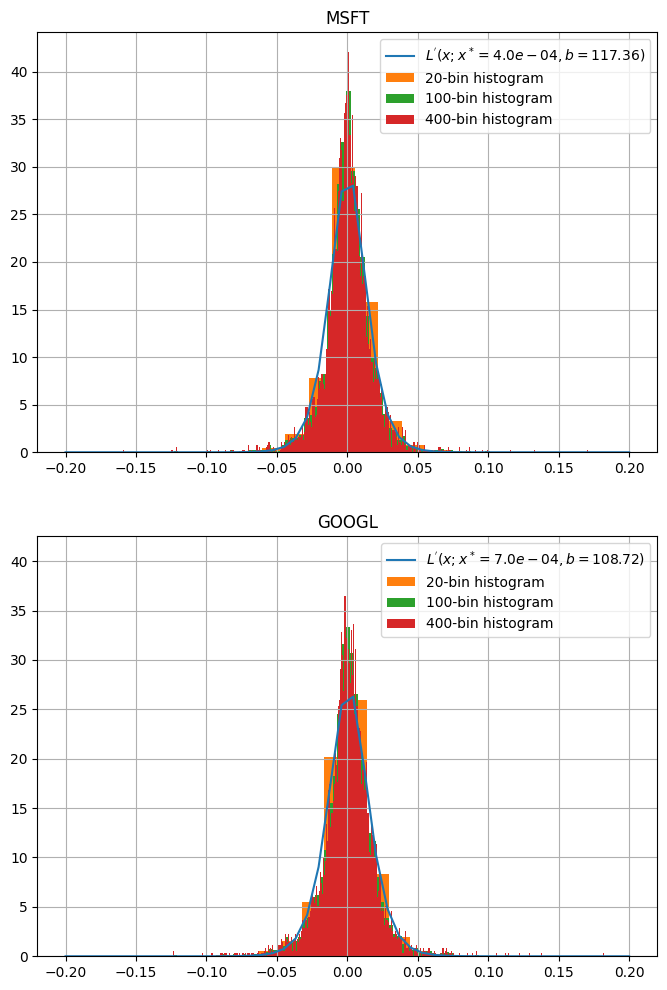

In [15]:
x_range = np.linspace(-0.2,0.2,50)
m = len(X.columns)
fig, axes = plt.subplots(2,1,figsize=(8,12))
for stock,ax in zip(X.columns,axes):
    ax.set_title(f"{stock}")
    x_star,b = logistic_fit(X[stock],dx=0.01)
    dL = logistic_derivate(x_range,x_star=x_star,b=b)
    ax.plot(x_range,dL,label=rf"$L^{{'}}(x; x^*={x_star:.1e},b={b:.2f})$")
    for k in (20,100,400):
        X[stock].hist(ax=ax,bins=k,density=True,label=f"{k}-bin histogram")
    ax.legend()
    ax.grid(True)
plt.show()

# 5 Descriptive Statistics
- Compute the two return rates’ all-time means $\{\mu_1, \mu_2\}$, variances $\{\sigma_1^2, \sigma_2^2\}$
Sharpe ratios $\{\gamma_1, \gamma_2\}$, and covariance $\sigma_{12}$.
- Repeat last step using only the data on the 𝐾 most recent days (i.e. 𝑡 ≥
𝑁 − 𝐾 + 1) for 𝐾 = 30, 100, and 300.

In [16]:
def describe_stats(X):
    mu = X.mean()
    sigma2 = X.var()
    gamma = X.mean()/X.std()
    display(pd.DataFrame({'mean':mu,'variance':sigma2,'sharp ration':gamma}))
    display(Markdown("**Covariance Table**:"))
    display(X.cov())

In [17]:
display(Markdown("### Descriptive Statistics(all-time):"))
describe_stats(X)

### Descriptive Statistics(all-time):

,mean,variance,sharp ration
MSFT,0.000583,0.000302,0.033525
GOOGL,0.000657,0.000359,0.034681


**Covariance Table**:

,MSFT,GOOGL
MSFT,0.000302,0.000195
GOOGL,0.000195,0.000359


In [18]:
for k in (30,100,300):
    display(Markdown(rf"### Descriptive Statistics($k={k}$ most recent days):"))
    describe_stats(X.iloc[-k:])

### Descriptive Statistics($k=30$ most recent days):

,mean,variance,sharp ration
MSFT,0.000668,0.000291,0.03916
GOOGL,-0.001349,0.000602,-0.05498


**Covariance Table**:

,MSFT,GOOGL
MSFT,0.000291,0.000240
GOOGL,0.000240,0.000602


### Descriptive Statistics($k=100$ most recent days):

,mean,variance,sharp ration
MSFT,0.001684,0.000454,0.079064
GOOGL,0.000852,0.000643,0.033592


**Covariance Table**:

,MSFT,GOOGL
MSFT,0.000454,0.000431
GOOGL,0.000431,0.000643


### Descriptive Statistics($k=300$ most recent days):

,mean,variance,sharp ration
MSFT,-0.000439,0.000480,-0.020013
GOOGL,-0.000979,0.000606,-0.039766


**Covariance Table**:

,MSFT,GOOGL
MSFT,0.000480,0.000445
GOOGL,0.000445,0.000606


##  6. Mean-Variance Analysis
We would like to perform a mean-variance analysis on $X_1(t)$ and $X_2(t)$ and
accordingly construct the minimum-risk portfolio $S_p(t) = pS_1(t)+(1-p)S_2(t)$  for some fraction of investment 𝑝 ∈ [0, 1].
- Determine 𝑝 according to the stocks’ all-time statistics.
- Plot the resultant portfolio’s $S_p(t)$ atop $S_1(t)$ and $S_2(t)$.

In [19]:
from scipy.linalg import null_space

def find_weight(X):
    Sigma = X.cov().to_numpy()
    N = len(Sigma)
    A = np.concatenate([2*Sigma,-np.ones([N,1])],axis=1)
    p = null_space(A)[:2]
    return p/p.sum()

In [20]:
p = find_weight(X)
p

array([[0.60514031],
       [0.39485969]])

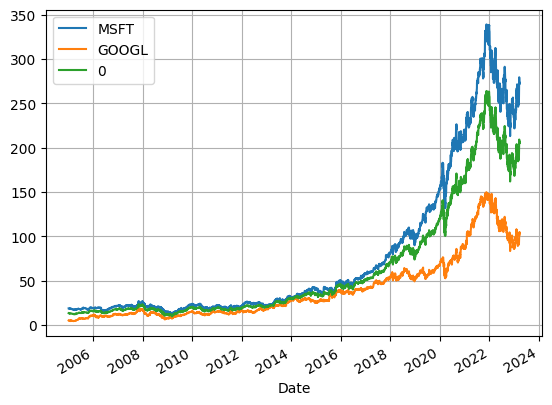

In [21]:
Sp=S@p
S.plot(ax=plt.gca())
Sp.plot(ax=plt.gca(),label="min-risk portfolio")
plt.grid(True)
plt.legend()
plt.show()

## 6.1 A 𝑲-Day Analysis
As the relevance of old data should decay, it is more sensible to consider the
stocks’ performance on the 𝐾 most recent days only. In other words, we only
infer information from $\{X(t-\tau)|\tau\in(0,K-1)\}$ at every moment 𝑡 .

Hence, the fraction of investment, now denoted by 𝑝(𝑡, 𝐾), varies with time
and depends on 𝐾. Complete the following tasks for 𝐾 = 30, 100, and 300.
- Plot 𝑝(𝑡, 𝐾).
- Plot the resultant portfolio $S_p(t,K)$ atop $S_1(t)$ and $S_2(t)$.
- Plot $S_p(t,K)$’s 𝐾-day Sharpe ratio $\gamma_p(t,K)=\mu_p(t,K)/\sigma_p(t,K)$.
- An all-time analysis in some sense sets 𝐾 → ∞. Discuss the effect of 𝐾 on
the portfolio’s performance.

In [22]:
def k_day_(X,S,K=30):
    Sp_df = S.copy()
    N = len(Sp_df)
    Sp_df['p'] = np.zeros(N)
    Sp_df['portfolio'] = np.zeros(N)
    Sp_df['gamma_p'] = np.zeros(N)
    for t in range(K,N):
        p = find_weight(X.iloc[t-K:t])
        Sp_df.p.iloc[t] = p[0]
        Sp_df.portfolio.iloc[t] = S.iloc[t]@p
        Sp_K = Sp_df.portfolio.iloc[t-K:t]
        Sp_df.gamma_p.iloc[t] = Sp_K.mean()/Sp_K.std()
    return Sp_df

In [23]:
Ks = (30,100,300)
Sps = [k_day_(X,S,K=K) for K in Ks]

/var/folders/xy/cf_z0zs94qv3nz1k8v6pj27r0000gn/T/ipykernel_63078/1227719923.py:12: RuntimeWarning: invalid value encountered in scalar divide
  Sp_df.gamma_p.iloc[t] = Sp_K.mean()/Sp_K.std()
/var/folders/xy/cf_z0zs94qv3nz1k8v6pj27r0000gn/T/ipykernel_63078/1227719923.py:12: RuntimeWarning: invalid value encountered in scalar divide
  Sp_df.gamma_p.iloc[t] = Sp_K.mean()/Sp_K.std()
/var/folders/xy/cf_z0zs94qv3nz1k8v6pj27r0000gn/T/ipykernel_63078/1227719923.py:12: RuntimeWarning: invalid value encountered in scalar divide
  Sp_df.gamma_p.iloc[t] = Sp_K.mean()/Sp_K.std()


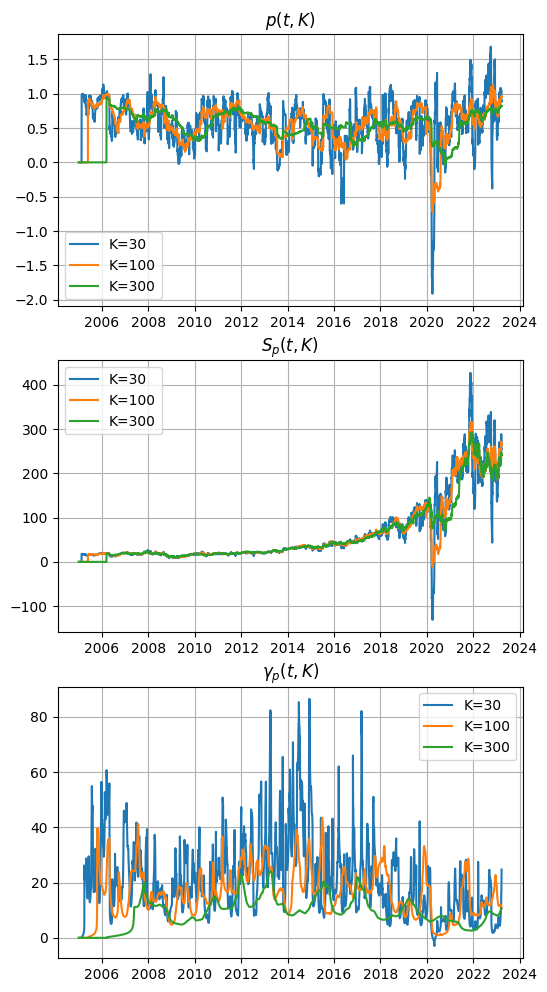

In [24]:
fig, axes = plt.subplots(len(Ks),1,figsize=(6,4*len(Ks)))
for Sp,K in zip(Sps,Ks):
    axes[0].plot(Sp.p,label=f"K={K}")
    axes[1].plot(Sp.portfolio,label=f"K={K}")
    axes[2].plot(Sp.gamma_p,label=f"K={K}")
axes[0].set_title("$p(t,K)$")
axes[1].set_title("$S_p(t,K)$")
axes[2].set_title("$\gamma_p(t,K)$")
for ax in axes:
    ax.grid(True)
    ax.legend()
plt.show()

## 7. Digitization of Time Series
Now focus on the first stock, so its subscript “1” is hereafter dropped and
implied. Digitize 𝑋(𝑡) as 𝑌 (𝑡) with three alphabets, viz. D for “down”, U for
“up”, and H for “hold”.
$$
Y(t)=
\begin{cases}
D, &X(t)<-\epsilon,\\
U, &X(t)>+\epsilon,\\
H, &otherwise.
\end{cases}
$$
Here let us use 𝜀 = 0.002, whereas you may of course choose other values in
real applications.
- Calculate the probability $P[Y(t)=y]$ for 𝑦 ∈ {D, U, H}.
- Calculate the conditional probability $P[Y(t+1)=y_1|Y(t)=y_2]$ for all
nine possible pairs of $(y_1,y_2)$ ∈ {D, U, H} × {D, U, H}.

In [25]:
def digitialize(X,epsilon=2e-3):
    return X.applymap(lambda x:'D' if x < -epsilon else 'U' if x > epsilon else 'H',na_action='ignore')

In [26]:
Y = digitialize(X)
Y

,MSFT,GOOGL
Date,,
2005-01-03,NaN,NaN
2005-01-04,U,D
2005-01-05,D,D
2005-01-06,H,D
2005-01-07,D,U
...,...,...
2023-03-16,U,U
2023-03-17,U,U
2023-03-20,D,D


In [48]:
Y1 = Y.MSFT

In [49]:
CY_1 = Y1.value_counts()
PY_1 = CY_1/CY_1.sum()
PY_1

U    0.439258
D    0.408070
H    0.152672
Name: MSFT, dtype: float64

In [50]:
PY_1_cond_1 = pd.DataFrame({'y1':Y1.shift(1),'y2':Y1}).value_counts()
for y1,y2 in product('DUH',repeat=2):
    PY_1_cond_1.loc[(y1,y2)] /= CY_1.loc[y2]
PY_1_cond_1

y1  y2
D   U     0.432473
U   D     0.455906
    U     0.415094
D   D     0.398717
U   H     0.464286
H   U     0.151936
    D     0.145377
D   H     0.361429
H   H     0.174286
dtype: float64

## 8. Association Rules
We would like to find out a five-day pattern 𝐴 that associates well with an
immediate down (D). Formally, a rule 𝑅 can be written as
𝑅 ∶ 𝐴 = {𝑌 (𝑡 − 4), 𝑌 (𝑡 − 3), 𝑌 (𝑡 − 2), 𝑌 (𝑡 − 1), 𝑌 (𝑡)} → 𝑌 (𝑡 + 1) = D (6)
or just 𝑅 ∶ 𝐴 → D. Since the consequence of 𝑅 is always D, we may simplify
our notation by labelling 𝑅 with only the five alphabets of 𝐴; for example, the
rule 𝑅 = UUUUU predicts a down after five consecutive ups. There are 3Θ =
243 possible rules.
- Divide 𝑌 (𝑡) into the “past” and the “future” at 𝑡 = 𝑀 ≈ 3𝑁 /4. We hope to
get good association rules by examining the history on the previous 3000
days and then apply them on the coming 1000 days to make a profit.
- Calculate the confidence of all the 243 rules in the past, then report the 10
rules with the highest confidence. Denote them as $\{R_{conf}\}_p$. (Hereafter a
subscript “𝑝” represents inference from the past data, whereas a subscript
“𝑓” represents inference the future data.)

In [51]:
def CY_(k:int,Y):
    return pd.DataFrame({f"y_{{t{'+' if i <= 1 else ''}{1-i}}}":Y.shift(k-i) for i in range(k+1)}).value_counts()

def PY_cond_(k:int,Y):
    CY_kmin = CY_(k-1,Y)
    CY_k = CY_(k,Y)
    PY_k = CY_k.copy()
    for idx in product('DUH',repeat=k+1):
        try:
            PY_k.loc[idx] /= CY_kmin.loc[idx[1:]]
        except KeyError:
            pass
    return PY_k

In [52]:
M = 3*len(Y1)//4
Y1_train = Y1.iloc[:M]
Y1_test = Y1.iloc[M:]
PY1_train_cond_5 = PY_cond_(5,Y1_train)
PY1_train_cond_5

y_{t+1}  y_{t+0}  y_{t-1}  y_{t-2}  y_{t-3}  y_{t-4}
D        D        U        D        D        U          0.475410
                           U        D        U          0.466667
         U        U        D        U        U          0.528302
U        D        U        D        U        D          0.560000
D        U        D        D        U        D          0.490909
                                                          ...   
H        U        D        U        H        D          0.100000
                  H        D        H        U          0.166667
                           H        D        H          0.250000
                                             U          0.100000
         H        H        U        H        U          0.333333
Length: 629, dtype: float64

In [53]:
Conf10_Y1_train_cond_5 = PY1_train_cond_5.sort_values(ascending=False).loc['D'].iloc[:10]
Conf10_Y1_train_cond_5

y_{t+0}  y_{t-1}  y_{t-2}  y_{t-3}  y_{t-4}
H        U        H        D        H          1.000000
U        D        D        H        H          1.000000
H        U        H        H        H          1.000000
D        D        H        H        H          1.000000
U        D        H        H        H          1.000000
D        H        H        D        H          1.000000
H        D        H        D        U          0.833333
U        D        H        U        H          0.800000
D        D        H        D        H          0.800000
H        H        U        D        D          0.750000
dtype: float64

In [54]:
CY1_test_5 = CY_(5,Y1_test)
Profit10_Y1_test_5 = CY1_test_5.sort_values(ascending=False).loc['D'].iloc[:10]
Profit10_Y1_test_5

y_{t+0}  y_{t-1}  y_{t-2}  y_{t-3}  y_{t-4}
U        U        D        D        U          14
         D        D        U        U          13
         U        U        U        D          12
         D        U        U        U          12
D        U        D        U        U          11
U        D        U        D        D          10
         U        U        U        U          10
                  D        U        U          10
D        U        D        D        U           9
                  U        D        U           9
dtype: int64

In [55]:
set(Conf10_Y1_train_cond_5.index).intersection(set(Profit10_Y1_test_5.index))

set()

In [56]:
Conf10_Y1_test_cond_5 = PY_cond_(5,Y1_test).sort_values(ascending=False).loc['D'].iloc[:10]
Conf10_Y1_test_cond_5

y_{t+0}  y_{t-1}  y_{t-2}  y_{t-3}  y_{t-4}
D        H        D        H        U          1.0
                           U        H          1.0
         D        D        H        H          1.0
         H        H        D        H          1.0
                           U        U          1.0
                           D        D          1.0
                  U        H        D          1.0
U        U        H        U        H          1.0
H        D        U        D        U          1.0
                  H        D        U          1.0
dtype: float64

In [57]:
set(Conf10_Y1_train_cond_5.index).intersection(set(Conf10_Y1_test_cond_5.index))

{('D', 'H', 'H', 'D', 'H'), ('H', 'D', 'H', 'D', 'U')}